In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
import torchvision
from torchvision import datasets, models, transforms

In [ ]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [ ]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageClassifierData as ImageClassifierData
from Transforms.ImageTransforms import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

In [ ]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')

In [ ]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [ ]:
im_size = 224

In [ ]:
train_tfms = TransformList([
        RandomScale(im_size, 1.2),
        RandomCrop(im_size),
        RandomLighting(0.05, 0.05),
        RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = TransformList([
        Scale(im_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
#test_tfms = TransformList([
#        RandomScale(im_size, 1.2),
#        RandomCrop(im_size),
#        RandomLighting(0.05, 0.05),
#        RandomHorizontalFlip()
#])
#
#for i in range(10, 20):
#    f, ax = plt.subplots(1,2, figsize=(10, 10))
#    print_example(images[i], ax[0])
#    im = open_image(DATA_PATH/images[i].filename) 
#    ax[1].imshow(test_tfms(im, 0)[0])
#    ax[0].get_xaxis().set_visible(False)
#    ax[0].get_yaxis().set_visible(False)
#    ax[1].get_xaxis().set_visible(False)
#    ax[1].get_yaxis().set_visible(False)   

In [12]:
batch_size = 8
data = ImageClassifierData.from_csv(DATA_PATH, MULTICLASS_CSV_PATH, batch_size, train_tfms, val_tfms)
num_classes = 8

In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.BatchNorm1d(num_features=num_ftrs),
    nn.Dropout(p=.5),
    nn.Linear(num_ftrs, num_classes)
)

In [14]:
criterion = nn.BCEWithLogitsLoss()
optim_fn = optim.Adam

In [15]:
sess = Session(model_ft, criterion, optim_fn, [*[1e-3] * 9, 1e-2])

In [16]:
sess.freeze() 

In [ ]:
lr_find(sess, data['train'], start_lr=1e-5)

In [17]:
sess.set_lr(5e-3)

In [19]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 3)

Training Loss: 0.395638  Validaton Loss: 0.358673 Validation Accuracy: 0.831580


Training Loss: 0.387871  Validaton Loss: 0.360193 Validation Accuracy: 0.831847


Training Loss: 0.384015  Validaton Loss: 0.357187 Validation Accuracy: 0.830956


In [20]:
for detail in accuracy.details:
    print(detail)

{'correct_pos': 0, 'correct_neg': 1041, 'false_pos': 2, 'false_neg': 359}
{'correct_pos': 101, 'correct_neg': 850, 'false_pos': 31, 'false_neg': 420}
{'correct_pos': 0, 'correct_neg': 1306, 'false_pos': 0, 'false_neg': 96}
{'correct_pos': 0, 'correct_neg': 1333, 'false_pos': 0, 'false_neg': 69}
{'correct_pos': 89, 'correct_neg': 1002, 'false_pos': 18, 'false_neg': 293}
{'correct_pos': 0, 'correct_neg': 1341, 'false_pos': 0, 'false_neg': 61}
{'correct_pos': 38, 'correct_neg': 1270, 'false_pos': 8, 'false_neg': 86}
{'correct_pos': 75, 'correct_neg': 874, 'false_pos': 33, 'false_neg': 420}


In [21]:
sess.save('TrainLayer1')

In [22]:
sess.load('TrainLayer1')

In [23]:
sess.unfreeze()

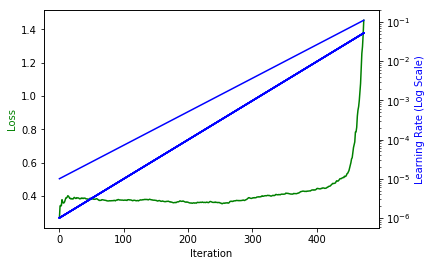

In [24]:
lr_find(sess, data['train'], start_lr=[*[1e-6] * 9, 1e-5])

In [25]:
sess.set_lr([*[1e-5] * 9, 1e-4])

In [26]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 7)

Training Loss: 0.419238  Validaton Loss: 0.408494 Validation Accuracy: 0.812233


Training Loss: 0.418997  Validaton Loss: 0.402242 Validation Accuracy: 0.814907


Training Loss: 0.391823  Validaton Loss: 0.391840 Validation Accuracy: 0.817671


Training Loss: 0.404155  Validaton Loss: 0.420308 Validation Accuracy: 0.812233


Training Loss: 0.397943  Validaton Loss: 0.393783 Validation Accuracy: 0.815710


Training Loss: 0.394788  Validaton Loss: 0.380048 Validation Accuracy: 0.820524


Training Loss: 0.367128  Validaton Loss: 0.370472 Validation Accuracy: 0.826141


In [ ]:
for detail in accuracy.details:
    print(detail)

In [ ]:
lr_scheduler.plot()

In [ ]:
sess.save('FullTrain')

In [ ]:
sess.load('FullTrain')

In [ ]:
sess.train(schedule, 8)

In [ ]:
sess.save('FullTrain2')

In [ ]:
sess.load('FullTrain2')